In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import fancyimpute

from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler, SMOTE

In [2]:
data = pd.read_excel('bank/bank-data.xlsx', '1')

### Quick Look at Data

In this dataset, there are total 45211 observations, with 39922 "no" response and 5289 "yes" response, which means it is an imbalance dataset. Imbalanced data refers to a problem with classification problems where the classes are not represented equally. The ratio of Class *no* to Class *yes* is more than 70:30.

Accurancy is not the metric to use when working with an imbalanced dataset. Instead, we can use confusion matrix, precison, recall, F1 score, ROC curves.
- **Confusion Matrix**: a table showing correct predictions (the diagonal) and the types of incorrect predictions made
- **Precision**: a measure of a classifiers exactness $$\frac{True Positive}{True Positive + False Postive}$$
- **Recall**: a measure of classifiers completeness
$$\frac{True Positive}{True Positive + False Negative}$$
- **F1 Score**: a weighted average of precision and recall
$$F = 2\cdot \frac{precision\cdot recall}{precision+recall}$$

Also, we need to sampling our dataset so that we will have even-up classes. 
- Over-sampling:
- Under-sampling:

Besides, generating synthetic samples to randomly sample the attributes from instances in the minority class.


In [3]:
data['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

### Exploratory Data Analysis

Before doing any exploratory data analysis, let's look into data and try to understand it.

- Categorical varibales: job, marital, education, default, housing, loan, contact, month, poutcome
- Numerical variables: age, balance, day, duration, campaign, pdays, previous

In [4]:
preview = pd.DataFrame(data, columns=data.columns[:-1])
preview.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


In [12]:
numerical = ['age','balance','day','duration','campaign','pday','previous']
categorical = ['job','marital','education','default','housing',
              'loan','contact','month','poutcome']
for col in categorical:
     print('\n{}\n{}'.format(col, preview[col].value_counts()))


job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

marital
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

default
no     44396
yes      815
Name: default, dtype: int64

housing
yes    25130
no     20081
Name: housing, dtype: int64

loan
no     37967
yes     7244
Name: loan, dtype: int64

contact
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

poutcome
unknown    36959
failur

In [14]:
def visualize_categorical(ax1, ax2, df, col, target):
    count = df[col].value_counts().sort_values(ascending=False)
    count.plot(kind='barh',ax=ax1)
    ax1.invert_yaxis()
    ax1.set_xlabel('Count')
    
    means = df.groupby(col)[target].mean()
    means[count.index].plot(kind='barh', ax=ax2)
    ax2.invert_yaxis()
    ax2.axvline(x=0.1169848, linewidth=1, color='red', linestyle='--')
    ax2.set_xlabel('Percetage Subscribed')

# df['y'].sum()/len(df['y'])

# Convert dependent variable into binary indicator
data.loc[data.y == 'no', 'y'] = 0
data.loc[data.y == 'yes', 'y'] = 1

data[['y']] = data[['y']].astype(int)

In [15]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


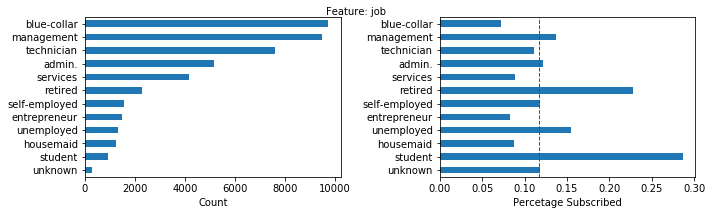

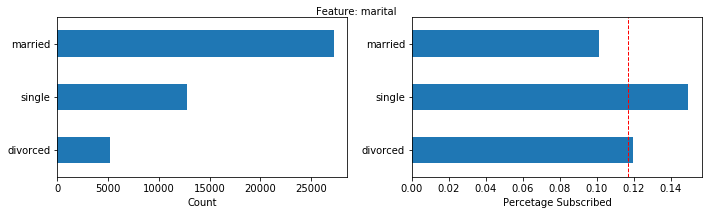

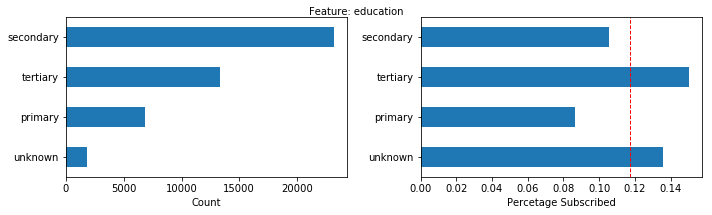

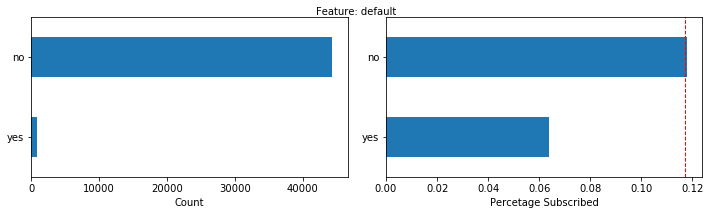

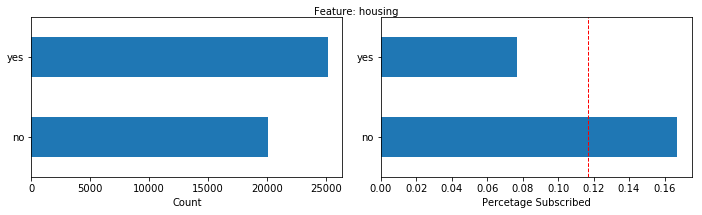

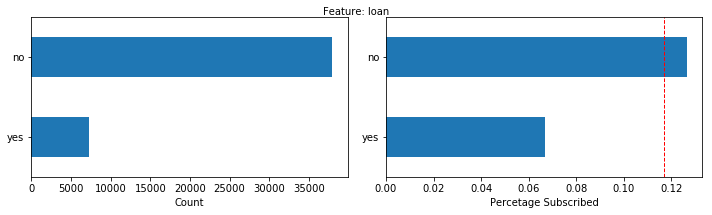

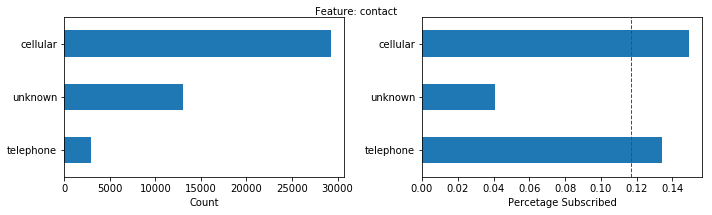

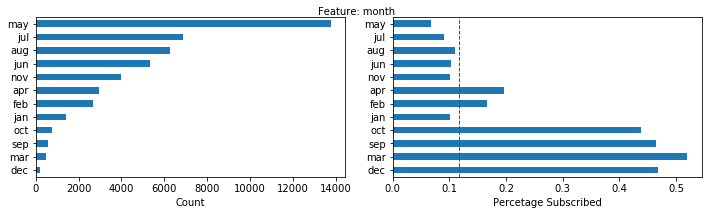

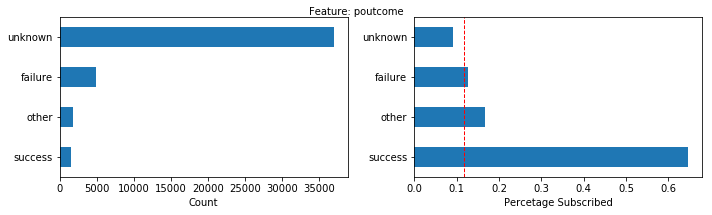

In [17]:
target = 'y'
train = ['age','balance','day','duration','campaign',
         'pday','previous','job','marital','education',
         'default','housing','loan','contact','month','poutcome']

for col in categorical:
    fig, axes = plt.subplots(1, 2, figsize=(10,3))
    ax11 = plt.subplot(1,2,1)
    ax12 = plt.subplot(1,2,2)
    fig.suptitle('Feature: %s'%col, fontsize=10)
    visualize_categorical(ax11,ax12,data,col,target)
    plt.tight_layout()

plt.show()

In [145]:
'''Impute'''
# data['job'].value_counts()/len(data['job'])        # unknown: 0.006370
data['education'].value_counts()/len(data['job'])    # unknown: 0.041074

secondary    0.513194
tertiary     0.294198
primary      0.151534
unknown      0.041074
Name: education, dtype: float64

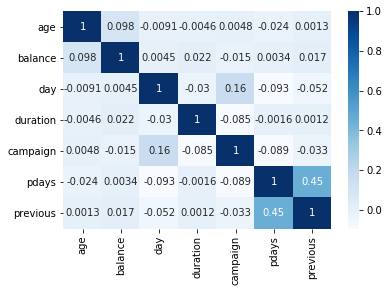

In [20]:
import seaborn as sns
df.loc[df.y == 'no', 'y'] = 0
df.loc[df.y == 'yes', 'y'] = 1
num_var = df[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous','y']]
sns.heatmap(num_var.corr(), annot=True, cmap="Blues")
plt.show()
#plt.matshow(num_var.corr())
#plt.show()

### Data Preprocessing

- Convert categorical variable into dummy/indicator variables.
- Set dependent variable to binary indicator, 0 for "no" and 1 for "yes".
- Normalize numerical variables to obtain mean zero and variance one

In [18]:
# Convert categorical variable into dummy/indicator variables
df = pd.get_dummies(data, columns=['job','marital','education','default','housing',
              'loan','contact','month','poutcome'])

# Standardiza numerical variables
scaler = StandardScaler()
num = df.iloc[:,0:7]
num = scaler.fit_transform(num)
num = pd.DataFrame(num)
num.columns = ['age','balance','day','duration','campaign','pday','previous']
df = pd.concat([num, df.iloc[:,7:]], axis=1)
df.head()

# before # of variable: 17
# now # of variable: 51

,age,balance,day,duration,campaign,pday,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,0.011016,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.288529,-0.437895,-1.298476,-0.416127,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.747384,-0.446762,-1.298476,-0.707361,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.571051,0.047205,-1.298476,-0.645231,-0.569351,-0.411453,-0.25194,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,-0.747384,-0.447091,-1.298476,-0.233620,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### Split Training and Testing data
Because of imbalanced data, *stratify* makes a split so taht the proportion of values in the sample produced will be the same as the proportion of vlalues provided to parameter *stratify*.

Let's now split data into a train set and a test set.

In [19]:
# Split training and test set
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1).values, df['y'].values, 
                                                    stratify=df['y'].values, random_state=0)

# percent of "yes" in training set: y_train.sum()/len(y_train) --> 0.117
# precent of "no" in testing set: y_test.sum()/len(y_test)     --> 0.117

### Imbalanced Data
http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

In [65]:
print(np.bincount(y_train))   
# original data:
# no 29941
# yes 3967

[29941  3967]


In [66]:
rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(np.bincount(y_train_subsample))

[3967 3967]


In [67]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
print(np.bincount(y_train_smote))

[29941 29941]


### PCA

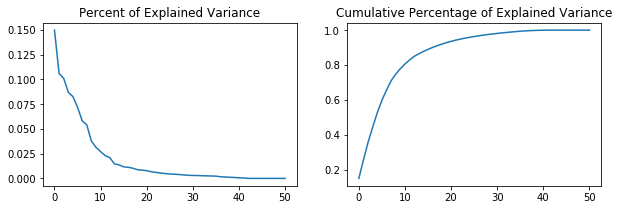

0.99155316790209014

In [47]:
'''PCA with Imbalanced Data'''
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(10,3))
ax11.plot(pca.explained_variance_ratio_)
ax11.title.set_text('Percent of Explained Variance')
cum_explained_var_ratio = []
for i in range(len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var_ratio.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var_ratio.append(cum_explained_var_ratio[i-1] + pca.explained_variance_ratio_[i])
ax12.plot(cum_explained_var_ratio)
ax12.title.set_text('Cumulative Percentage of Explained Variance')
plt.show()
# 17 variables -> 90%
# 24 variables -> 95%
# 35 variables -> 99%

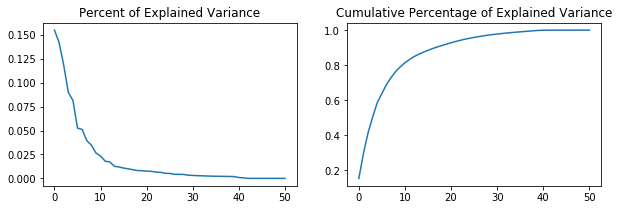

[0.15493135155832446,
 0.29693125614022875,
 0.41537656224682906,
 0.50523530100569869,
 0.58676894316235451,
 0.63926003059702596,
 0.69045181337320194,
 0.72995660007560403,
 0.76465226486667448,
 0.79115227196064253]

In [60]:
'''PCA with Balanced Data: RandomUnderSampler'''
X_train_pca = pca.fit_transform(X_train_subsample)
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(10,3))
ax11.plot(pca.explained_variance_ratio_)
ax11.title.set_text('Percent of Explained Variance')
cum_explained_var_ratio = []
for i in range(len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var_ratio.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var_ratio.append(cum_explained_var_ratio[i-1] + pca.explained_variance_ratio_[i])
ax12.plot(cum_explained_var_ratio)
ax12.title.set_text('Cumulative Percentage of Explained Variance')
plt.show()
cum_explained_var_ratio[:10]
# 18 -> 90%
# 25 -> 95%
# 36 -> 99%

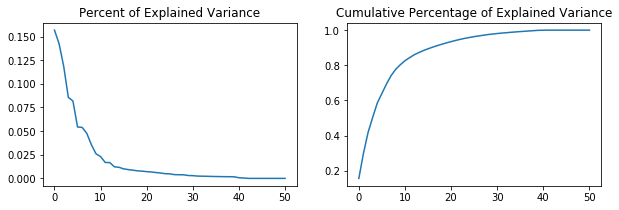

[0.15685123881337407,
 0.29930515368053168,
 0.41788286756894505,
 0.5036384096759734,
 0.58553665420582879,
 0.63993786210681558,
 0.69388779132040757,
 0.74160835676828563,
 0.777232914167721,
 0.80327581137094128]

In [61]:
'''PCA with Balanced Data: RandomUnderSampler'''
X_train_pca = pca.fit_transform(X_train_smote)
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(10,3))
ax11.plot(pca.explained_variance_ratio_)
ax11.title.set_text('Percent of Explained Variance')
cum_explained_var_ratio = []
for i in range(len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var_ratio.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var_ratio.append(cum_explained_var_ratio[i-1] + pca.explained_variance_ratio_[i])
ax12.plot(cum_explained_var_ratio)
ax12.title.set_text('Cumulative Percentage of Explained Variance')
plt.show()
cum_explained_var_ratio[:10]

In [64]:
print(X_train_smote.shape)
print(np.bincount(y_train_smote))
print(np.bincount(y_train))

(59882, 51)
[29941 29941]
[29941  3967]


### Ensemble Methods

In [26]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
